# Smart meter Time-series data analysis using LSTM

Based on the great article of Jason Brownlee PhD: [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/?utm_source=drip&utm_medium=email&utm_campaign=MLM+Newsletter+December+20%2C+2024&utm_content=Deploy+Machine+Learning+Models+with+Streamlit+%E2%80%A2+7+Machine+Learning+Projects+For+Beginners)

## Definition of data

We are going to use S02 files (hourly data). The columns of the CSV are as follows:

1. _date_ Date in format dd/mm/yyyy

2. _time_: time in format hh:mm:ss

3. _global_active_power_: household global minute-averaged active power (in KWh)

4. _global_reactive_power_: household global minute-averaged reactive power (in KWh)

5. _voltage_: minute-averaged voltage (in volt)

6. _global_intensity_: household global minute-averaged current intensity (in ampere)

## Power consumption regression using LSTM with Time Steps

In [ ]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# fix random seed for reproducibility
tf.random.set_seed(20)

# load the dataset
dataframe = pd.read_csv('/home/antonroman/src/smart_meter_data_analysis/data_processing/aggregated_reactive/agg_values_S02_100.csv', usecols=[1], engine='python')



In order to make a valid simulation we need to remove outliers to get more accurate predictions and also, allow a correct visualization of the data.

In [ ]:

from scipy import stats
dataframe['z_score']=stats.zscore(dataframe['R1'])

# manual inspection of outliers
filtered_df = dataframe[dataframe["R1"] > 10000000]
print(filtered_df)

# manual inspection of outliers after z_score removal
dataframe = dataframe[dataframe['z_score'].abs()<=2]
dataframe = dataframe.drop(columns='z_score')
print(dataframe)

dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)

Data needs to be normalized to make sure the LSTM algortihm runs correctly. 

In [ ]:

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
plt.plot(dataset)


With time series data, the sequence of values is important. A simple method that you can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets, with 67% of the observations used to train the model, leaving the remaining 33% for testing the model

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

In [ ]:
print(scaler.inverse_transform(dataset))
plt.plot(scaler.inverse_transform(dataset))



This will create a dataset where X is the power consumed at a given time (t), and Y is the power consumed at the next time (t + 1).

In [ ]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of [samples, time steps, features].

Currently, the data is in the form of [samples, features], and you are framing the problem as one time step for each sample. You can transform the prepared train and test input data into the expected structure using `numpy.reshape()` as follows:

In [ ]:

# reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
# testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs, and a batch size of 1 is used.

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Once the model is fit, you can estimate the performance of the model on the train and test datasets. This will give you a point of comparison for new models.

Note that you will invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (KWh per hour).

In [ ]:
print(trainX.shape)
print(testX.shape)

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [ ]:
print(trainPredict.shape)
print(testPredict.shape)
print(trainPredict)
print(testPredict)


In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
print(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In order to identify LSTM performance for anomaly detection, we try to identiy the anomalies in the test samples by following the steps as follows:
1. Calculate the average train error in absolute value. 
2. Define the threshold to consider the error between original and forecasted value as an anomaly. 
3. Calculate what values can be considered as anomalies.


More advance techniques, such as giving a value within a probability of being an anomaly required a more advanced processing. 

2716
[ True  True  True ...  True  True  True]
[0. 0. 0. ... 0. 0. 0.]
Train error:  120318.28565774165
Anomaly threshold:  360954.85697322496
Number of anomalies:  181


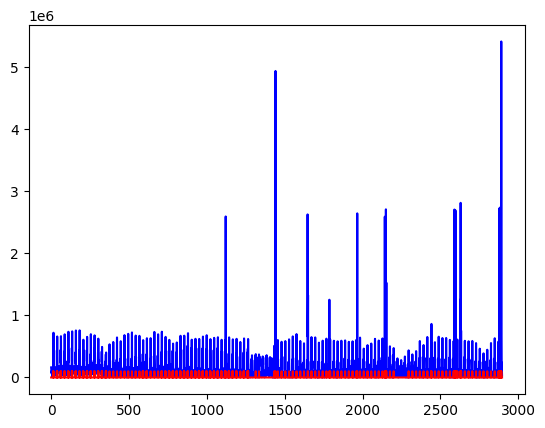

In [81]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
norm_testY = scaler.fit_transform(testY)
#print(testY)
#print(testY.shape)

#print(norm_testY)
norm_testPredict = scaler.fit_transform(testPredict)
#print(testPredict)
#print(testPredict.shape)
#print(norm_testPredict)
# Calculate reconstruction error
#train_error = np.mean(np.abs(np.traspose(norm_testY[0]) - norm_testPredict[:,0]))
train_error = np.mean(np.abs(np.transpose(testY[0]) - testPredict[:,0]))
#train_error = np.mean(norm_testPredict[:,0])

# Define threshold for anomaly detection (adjust based on your data)
threshold_above = train_error * 3 
threshold_below = train_error / 1

# Detect anomalies
test_difference = np.abs(np.transpose(testY[0]) - testPredict[:, 0])
# Create a boolean mask where the absolute difference is below the threshold
mask = (np.abs(test_difference) < threshold_above) | (test_difference < threshold_below)
print(np.count_nonzero(mask))
print(mask)
# Set values below threshold to zero
test_anomalies = np.copy(test_difference)
test_anomalies[mask] = 0
test_anomalies[~mask] = 100000
print(test_anomalies)

plt.plot(test_difference, color='blue')
plt.plot(test_anomalies, color='red')

anomalies = np.where(np.abs(np.transpose(testY[0]) - testPredict[:, 0]) > threshold)
#print(len(anomalies))
#print(anomalies)

# Print detected anomalies
print("Train error: ", train_error)
print("Anomaly threshold: ", threshold_above)
print("Number of anomalies: ", len(anomalies[0]))
#print("Detected Anomalies:", anomalies)
#plt.plot(train_error)


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, you must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), color='blue')
plt.plot(trainPredictPlot, color='red')
plt.plot(testPredictPlot, color='green')
plt.show()

## Power consumption regression with LSTM Using the Window Method

In [ ]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
print(trainX)

In [ ]:
# create and fit the LSTM network
model_window = Sequential()
model_window.add(LSTM(4, input_shape=(1, look_back)))
model_window.add(Dense(1))
model_window.compile(loss='mean_squared_error', optimizer='adam')
model_window.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

In [ ]:
# make predictions
trainPredict = model_window.predict(trainX)
testPredict = model_window.predict(testX)

In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [ ]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [ ]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()